# Testing PMT with chamber windows blocked

- Hamamatsu R375 PMT
- SRS445A amplifier @125x amplification & @50 Ohm input impedance
- SRS HV PSU @1400 V
- 5 MHz low pass filter before the last amplification channel.
- NI PXIe-5171 Oscilloscope

Lights are at lowest brightness setting.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import simps

In [2]:
data_loc = "D:/PMT Single Photons/2018_12_31/"
fname = "single_photons_lightsoff_50Ohm_ampstage123_5MHzLP.hdf5"

In [3]:
%%time
data = np.empty([805306192,1], dtype = np.int16)

with h5py.File(data_loc+fname, 'r') as f:
    attrs = dict(f['waveforms/record_0'].attrs.items())
    data = f['waveforms/record_0'].value
    
print(attrs)

{'gain': 9.465828952670563e-05, 'offset': -0.0006035383557900786, 'x_increment': 4e-09, 'absolute_initial_x': 1463621.766328728}
Wall time: 8.95 s


In [4]:
%%time
peakLocs, peakInfo = find_peaks(-1*data, height = 90, distance = 200, width = 10)
print(len(peakLocs))

45020
Wall time: 50.4 s


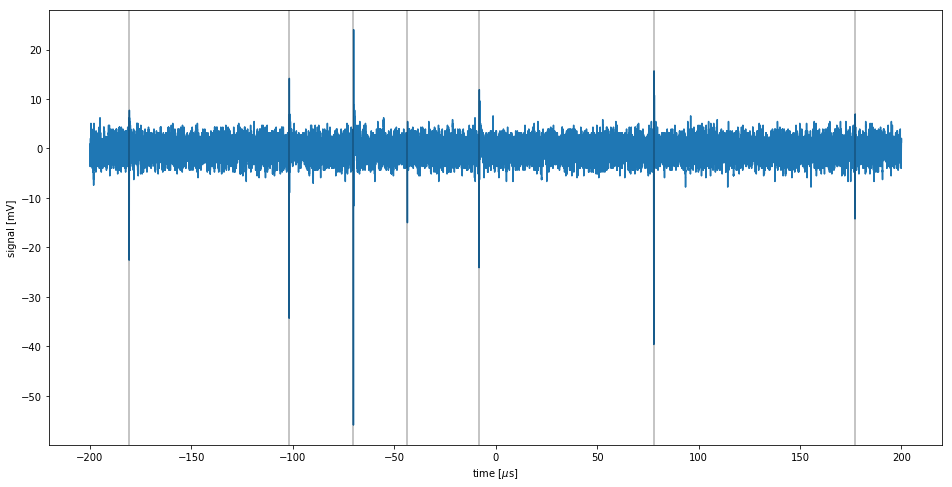

In [5]:
gain = attrs['gain']
offset = attrs['offset']

start, stop = 100000, 200000
peaks = peakLocs[(peakLocs >= start) & (peakLocs < stop)]
y = (data[start:stop]*gain+offset)*1e3
x = np.linspace(-len(y)//2,len(y)//2-1,len(y))*attrs['x_increment']*1e6

fig, ax = plt.subplots(figsize = (16,8))
ax.plot(x,y)
[ax.axvline((p*4e-9-(start+stop)/2*4e-9)*1e6, color = 'black', alpha = 0.3) for p in peaks]
ax.set_xlabel('time [$\mu$s]')
ax.set_ylabel('signal [mV]');

Text(0.5, 0, '[$\\mu$s]')

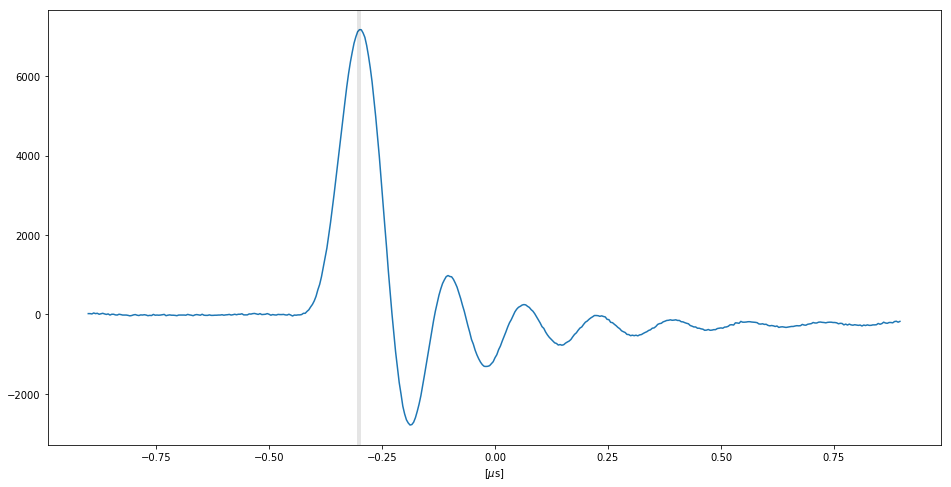

In [6]:
peakID = 36055
width = 300
start, stop = peakLocs[peakID]-width//2, peakLocs[peakID]+width
y = -data[start:stop]
x = np.linspace(-len(y)//2,len(y)//2-1,len(y))*attrs['x_increment']*1e6
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(x,y)
ax.axvline((peakLocs[peakID]*4e-9-(start+stop)/2*4e-9)*1e6, color = 'black', alpha = 0.1, lw = 4)
ax.set_xlabel(r'[$\mu$s]')

In [7]:
from tqdm import tqdm_notebook as tqdm
def get_peakheights(fname, height, distance, width):
    peakHeights = []

    with h5py.File(fname, 'r') as f:
        for dset in tqdm(f['waveforms/']):
            data = np.empty([805306192,1], dtype = np.int16)
            attrs = dict(f['waveforms/record_0'].attrs.items())
            data = f['waveforms/'+dset].value
            peakLocs, peakInfo = find_peaks(-1*data, height = height, distance = distance, width = width)
            peakHeights.append(peakInfo['peak_heights']*attrs['gain']+attrs['offset'])
        peakHeights = np.concatenate(peakHeights).ravel()
    return peakHeights

In [8]:
fname = "single_photons_lightsoff_50Ohm_ampstage123_5MHzLP.hdf5"
peakheights_lightsoff = get_peakheights(data_loc+fname, 90,200,10)

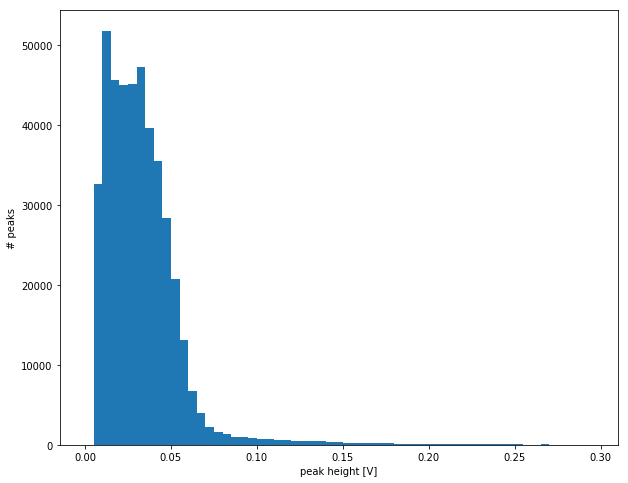

In [9]:
bins = np.arange(0,0.3,5e-3)
fig, ax = plt.subplots(figsize = (10,8))
hist_off = ax.hist(peakheights_lightsoff, bins = bins);
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');

In [10]:
fname = "single_photons_lightson_50Ohm_ampstage123_5MHzLP_morelight.hdf5"
peakHeights_lightson = get_peakheights(data_loc+fname, 90,200,10)

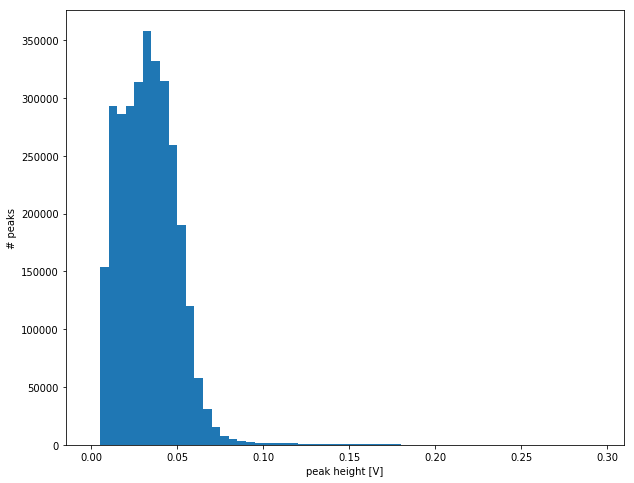

In [12]:
bins = np.arange(0,0.3,5e-3)
fig, ax = plt.subplots(figsize = (10,8))
hist_on = ax.hist(peakHeights_lightson, bins = bins);
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');

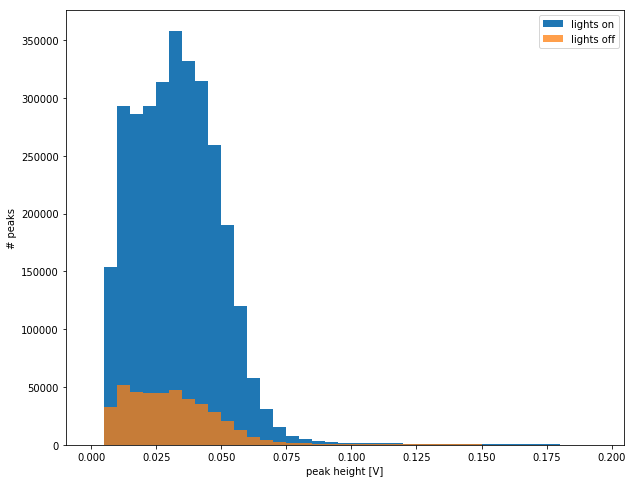

In [16]:
bins = np.arange(0,0.2,5e-3)

fig, ax = plt.subplots(figsize = (10,8))
hist_on = ax.hist(peakHeights_lightson, bins = bins, label = 'lights on');
hist_off = ax.hist(peakheights_lightsoff, bins = bins, alpha = 0.75, label = 'lights off');
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.legend();

Text(0.5, 1.0, 'difference')

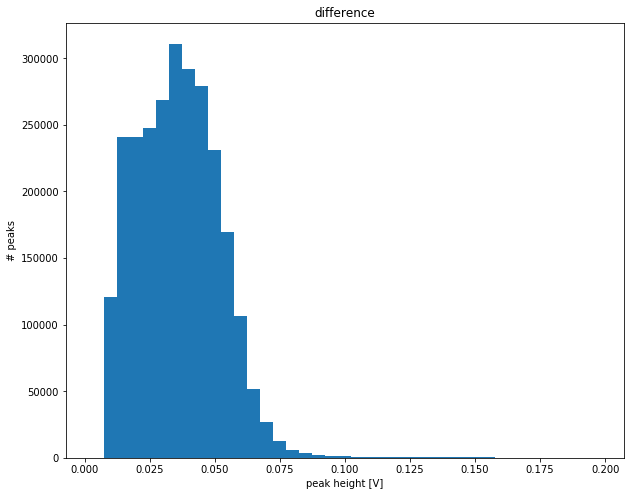

In [17]:
xx = np.diff(hist_on[1])+hist_on[1][:-1]
yy = hist_on[0]-hist_off[0]

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xx,yy, width = np.diff(xx)[0])
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.set_title('difference')

mean : 34.63 mV


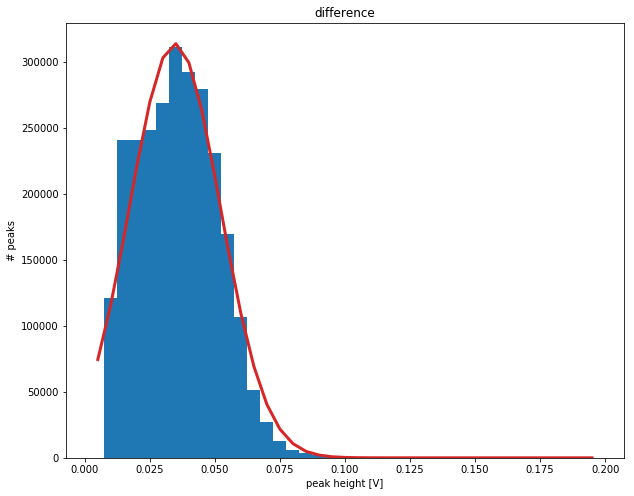

In [18]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sig):
    return amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

xx, yy = np.diff(hist_on[1])+hist_on[1][:-1], hist_on[0]-hist_off[0]
mask = xx > 0
xx = xx[mask]
yy = yy[mask]

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xx,yy, width = np.diff(xx)[0])
ax.set_xlabel('peak height [V]')
ax.set_ylabel('# peaks');
ax.set_title('difference')

popt, pcov = curve_fit(gaussian, xx, yy)
print('mean : {:.2f} mV'.format(popt[1]*1e3))

ax.plot(xx, gaussian(xx, *popt), 'C3', lw = 3);

In [19]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq

show_errors = False

def get_peakwidths(fname, height, distance, peak_width, find_width):

    peakWidths = []
    xx = np.linspace(-find_width//2,find_width-1,1.5*find_width)*4e-9*1e6
    
    with h5py.File(fname, 'r') as f:
        for dset in tqdm(f['waveforms/']):
            data = np.empty([805306192,1], dtype = np.int16)
            attrs = dict(f['waveforms/record_0'].attrs.items())
            data = f['waveforms/'+dset].value
            peakLocs, peakInfo = find_peaks(-1*data, height = height, distance = distance, width = peak_width)
            for peakID, peakLoc in enumerate(tqdm(peakLocs, desc = dset)):
                start, stop = peakLoc-find_width//2, peakLoc+find_width
                yy = data[start:stop]
                try:
                    intp = interp1d(xx,yy)
                except Exception as e:
                    print(len(xx),len(yy))
                    if show_errors:
                        print(peakLoc)
                        print(peakInfo['peak_heights'][peakID])
                        fig, ax = plt.subplots(figsize = (12,8))
                        ax.plot(xx, intp(xx))
                        ax.plot(xx, half_max(xx)*np.ones(len(xx)))
                        raise e
                    else:
                        continue
                half_max = lambda x: yy.min()/2
                intersect = lambda x: intp(x)-half_max(x)
                try:
                    left = brentq(intersect, xx.min(), 0)
                except Exception as e:
                    if show_errors:
                        print(peakLoc)
                        print(peakInfo['peak_heights'][peakID])
                        fig, ax = plt.subplots(figsize = (12,8))
                        ax.plot(xx, intp(xx))
                        ax.plot(xx, half_max(xx)*np.ones(len(xx)))
                        raise e
                    else: 
                        continue
                try:
                    right = brentq(intersect, 0, xx.max())
                except Exception as e:
                    if show_errors:
                        print('peak location : {0}'.format(peakLoc))
                        print('peak height : {0}'.format(peakInfo['peak_heights'][peakID]))
                        fig, ax = plt.subplots(figsize = (12,8))
                        ax.plot(xx, intp(xx))
                        ax.plot(xx, half_max(xx)*np.ones(len(xx)))
                        raise e
                    else:
                        continue
                peakWidths.append(right-left)
        return np.array(peakWidths)

In [20]:
fname = "single_photons_lightson_50Ohm_ampstage123_5MHzLP_morelight.hdf5"
peak_widths = get_peakwidths(data_loc+fname, 270,200,10,200)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


gaussian mean : 9.41e-02 us
standard mean : 9.27e-02 us


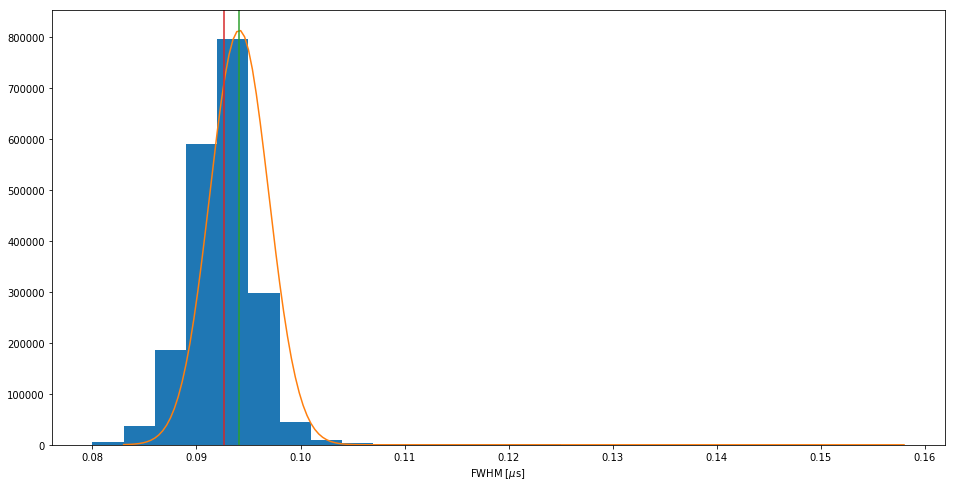

In [25]:
bins = np.arange(0.08,0.16,3e-3)

fig, ax = plt.subplots(figsize = (16,8))
hist = ax.hist(peak_widths, bins = bins);
ax.set_xlabel('FWHM [$\mu$s]')

xx = np.diff(hist[1])+hist[1][:-1]
yy = hist[0]
popt, pcov = curve_fit(gaussian, xx, yy, p0 = (yy.max(), peak_widths.mean(), peak_widths.std()))
xxx = np.linspace(xx.min(), xx.max(), 201)
ax.plot(xxx, gaussian(xxx, *popt))

ax.axvline(popt[1], color = 'C2')
ax.axvline(peak_widths[peak_widths < 0.175].mean(), color = 'C3')

print('gaussian mean : {0:.2e} us'.format(popt[1]))
print('standard mean : {0:.2e} us'.format(peak_widths[peak_widths < 0.175].mean()))

In [27]:
import pint

ureg = pint.UnitRegistry()

peak = 34.63e-3 * ureg.volt
elementary_charge = 1.6021766*1e-19 * ureg.coulomb
pmt_pulse = 92.7e-9 * ureg.second
load = 50 * ureg.ohm
amplifier_gain = 125


pmt_gain = (peak / ((elementary_charge/pmt_pulse)*load*amplifier_gain)).to_root_units()
print('PMT gain : {0:.2e}'.format(pmt_gain))

PMT gain : 3.21e+06 dimensionless
